In [1]:
def findexact(str, substr, index=0):
  offset = str.find(substr)
  ln = len(substr)
  if not index:
    return offset
  return offset + ln + findexact(str[offset+ln :], substr, index-1)

In [2]:
!pip install gdown
!pip install docx2txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3980 sha256=1a041c6f67a77aa7db213955c368ff0d56431a7496e4b3be429315d5620daf97
  Stored in directory: /root/.cache/pip/wheels/55/f0/2c/81637d42670985178b77df6d41b9b6c6dc18c94818447414b9
Successfully built docx2txt


In [3]:
import gdown
import docx2txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score

In [4]:
!gdown 12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb

Downloading...
From: https://drive.google.com/uc?id=12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb
To: /content/CCXXXI.docx
100% 355k/355k [00:00<00:00, 107MB/s]


In [5]:
txt = docx2txt.process("CCXXXI.docx")

In [6]:
df = pd.DataFrame(columns=["text", "name"])
df["text"] = list(filter(lambda x: len(x) > 20, txt.split(sep="\n(")))
df["day"] = df["text"].map(lambda x: int(x[findexact(x, " ") + 1 : findexact(x, " ", 1)]))
df["month"] = df["text"].map(lambda x: x[findexact(x, " ", 1) + 1 : findexact(x, ".", 1)])
df["greg_day"] = df["text"].map(lambda x: int(x[: findexact(x, ".")]))
df["greg_month"] = df["text"].map(lambda x: int(x[findexact(x, ".") + 1 : findexact(x, ")")]))
df["name"] = df["text"].map(lambda x: x[findexact(x, ".", 1) + 2 : findexact(x, "\n")])
df["text"] = df["text"].map(lambda x: " ".join(x[findexact(x, "\n") :].split()))

for i in range(29, df.shape[0], 30):
  df.at[i, "text"] = df.at[i, "text"][:df.at[i, "text"].rfind(" ")]

In [7]:
df["sentences"] = df["text"].map(lambda x: len(x.replace("?", ".").replace("!", ".").split(". ")))
df["words"] = df["text"].map(lambda x: len(x.replace("-", "").split()))
df["symbols"] = df["text"].map(lambda x: len(x.replace(" ", "")))
df["capitals"] = df["text"].map(lambda x: len(list(filter(lambda c: c.isupper(), x))))
df["dashes"] = df["text"].map(lambda x: len(list(filter(lambda w: w == "-", x.split()))))
df["questions"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "?", x))))
df["exclamations"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "!", x))))

In [8]:
fandoms = {
    "réséda" : "chguestk", "piment" : "chguestk", "betterave" : "chguestk", "alisier" : "chguestk",
    "orange" : "chguestk", "chicorée" : "chguestk", "cire" : "chguestk", "ajonc" : "chguestk",
    "sabine" : "chguestk",
    "bœuf" : "cliff", "chou-fleur" : "cliff", "olive" : "cliff", 
    "tournesol" : "lesmis", "raiponce" : "lesmis",
    "houille" : "notredame", 
    "orge" : "starmania",
    "nèfle" : "dracula",
    "érable sucré" : "persona",
    }
df["fandom"] = df["name"].map(lambda x: fandoms[x] if x in fandoms else "-")

In [9]:
df

,text,name,day,month,greg_day,greg_month,sentences,words,symbols,capitals,dashes,questions,exclamations,fandom
0,люди не изменились. ароматная жидкость мягко к...,raisin,1,vendémiaire,23,9,17,238,1339,0,4,2,0,-
1,Сафран горд своим прозвищем. нет большого смыс...,safran,2,vendémiaire,24,9,21,333,1940,5,3,1,1,-
2,Кристине исполняется четыре года. белокурая ма...,châtaigne,3,vendémiaire,25,9,30,514,2824,10,13,5,2,-
3,с тихим звонком открываются двери лифта. мягки...,colchique,4,vendémiaire,26,9,37,339,1907,30,12,6,2,-
4,Келлер Долль привычным движением запрыгивает в...,cheval,5,vendémiaire,27,9,22,374,2252,10,4,0,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,"время, как известно, лечит - если вам так не к...",tourbe,1,nivôse,22,12,15,292,1651,0,8,1,0,-
91,"бред пеленой застилает глаза, превращает прохо...",houille,2,nivôse,23,12,18,321,1769,2,9,0,0,notredame
92,каждым живым существом в определëнный момент р...,bitume,3,nivôse,24,12,15,276,1727,0,6,0,0,-
93,"вот, значит, как ты обходишься со мной после в...",soufre,4,nivôse,25,12,21,310,1650,0,5,2,0,-


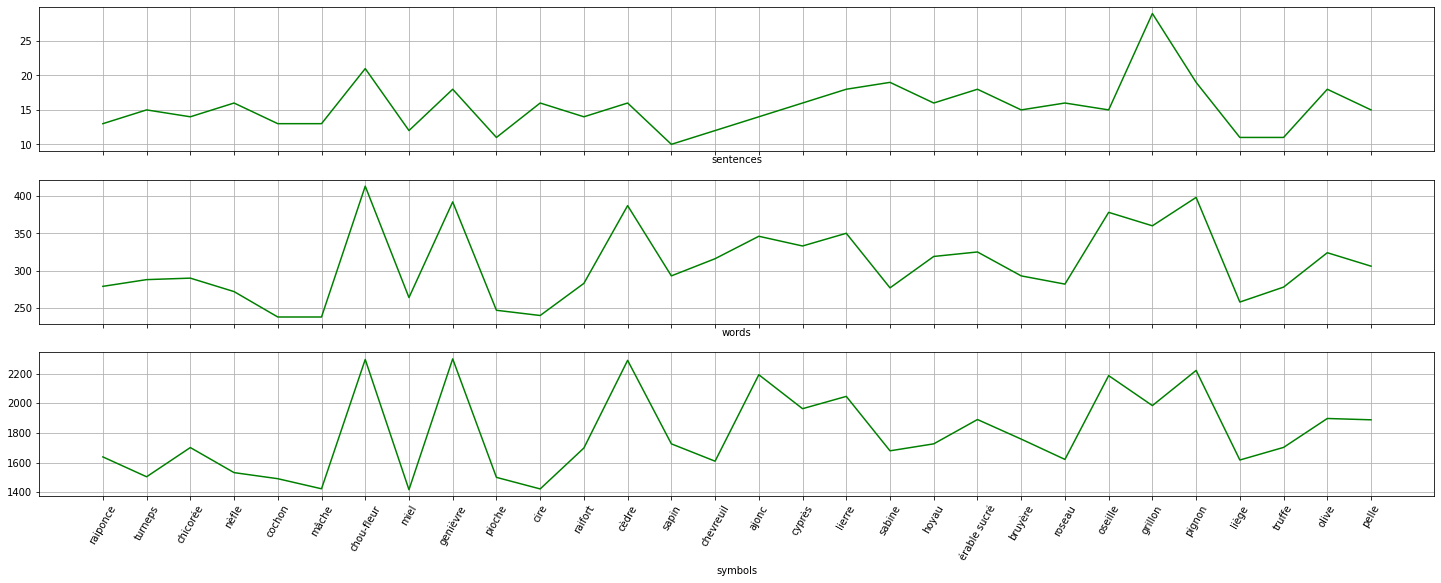

In [54]:
months = ["vendémiaire", "brumaire", "frimaire", "nivôse", "pluviôse", "ventôse",
          "germinal", "floréal", "prairial", "messidor", "thermidor", "fructidor"]

batch = df[df["month"] == months[2]]

plots = ["sentences", "words", "symbols"]
# plots = ["capitals", "dashes", "questions", "exclamations"]
fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(25,3 * len(plots)))
for i in range(len(plots)):
  axs[i].plot(batch["name"], batch[plots[i]], 'g')
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.xticks(rotation=60)
plt.show()

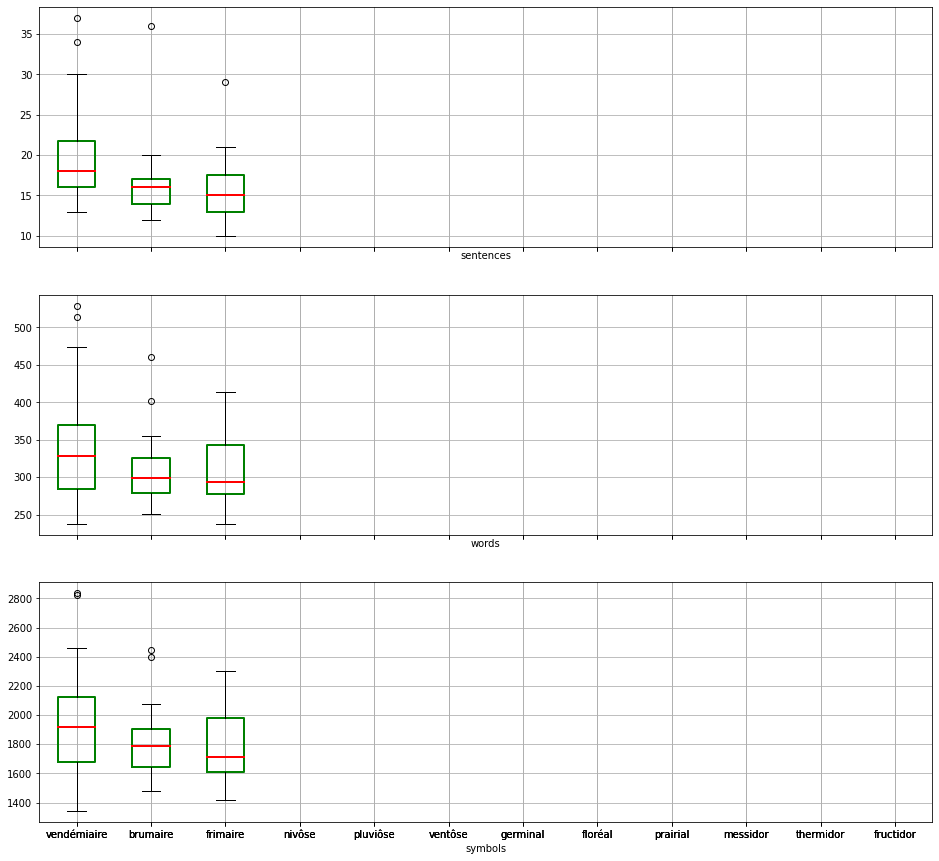

In [62]:
boxprops = dict(linewidth=2, color='g')
medianprops = dict(linewidth=2, color='r')

plots = ["sentences", "words", "symbols"]

fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(16, 5 * len(plots)))
for i in range(len(plots)):
  stat = pd.DataFrame(columns=months)
  for month in months:
    stat[month] = df[df["month"] == month][plots[i]].reset_index(drop=True)
  axs[i].boxplot(stat.to_numpy(), labels=stat.columns, widths=0.5, boxprops=boxprops, medianprops=medianprops)
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.suptitle("")
plt.show()

In [63]:
target_column = "sentences"
dum_df = pd.get_dummies(data=df, columns=["month", "fandom"]).drop(columns=["name", "text"])
X, y = dum_df.drop(columns=[target_column]), dum_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

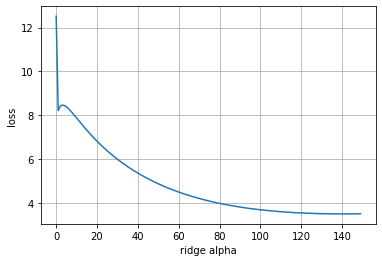

In [64]:
params = np.arange(0, 150, 1)
# params = np.arange(0, 1, 0.02)

loss = []
for p in params:
  model = Ridge(alpha=p).fit(X_train, y_train)
  y_pred = model.predict(X_test)
  loss.append(mean_squared_error(y_test, y_pred))
plt.plot(params, loss)
plt.grid()
plt.xlabel("ridge alpha")
plt.ylabel("loss")
plt.show()

alpha = params[np.argmin(loss)]

linreg MSE:  6.631578947368421
ridge MSE:  3.4905251793905405


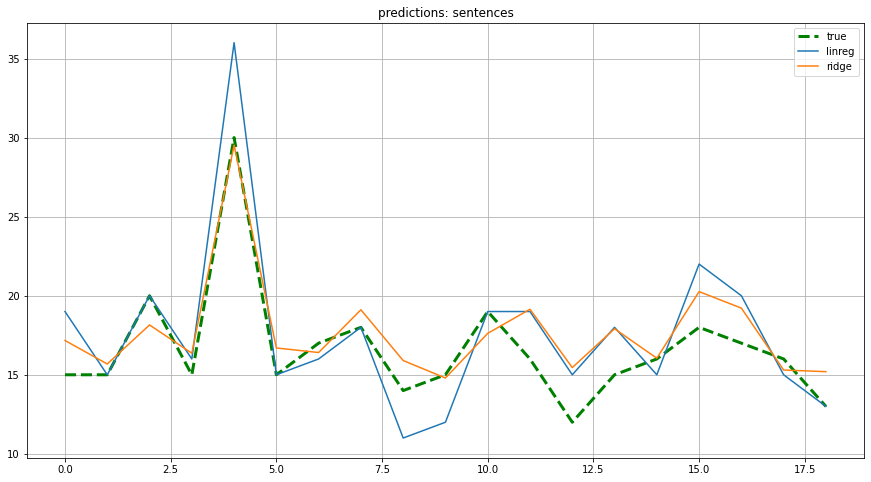

In [65]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_reg = reg.predict(X_test).astype(int)
ridge = Ridge(alpha=alpha).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("linreg MSE: ", mean_squared_error(y_test, y_pred_reg))
print("ridge MSE: ", mean_squared_error(y_test, y_pred_ridge))

plt.rcParams["figure.figsize"] = (15, 8)
plt.plot(range(len(y_test)), y_test, label="true", color='g', linewidth=3, linestyle="dashed")
plt.plot(range(len(y_pred_reg)), y_pred_reg, label="linreg")
plt.plot(range(len(y_pred_ridge)), y_pred_ridge, label="ridge")
plt.title("predictions: " + target_column)
plt.grid()
plt.legend()
plt.show()

In [66]:
ops = list(map(lambda x: x[:findexact(x, " ", 0)], df["text"]))
ops.sort(key=lambda x: x.lower())

In [ ]:
# todo: something that has to do with text processing ?

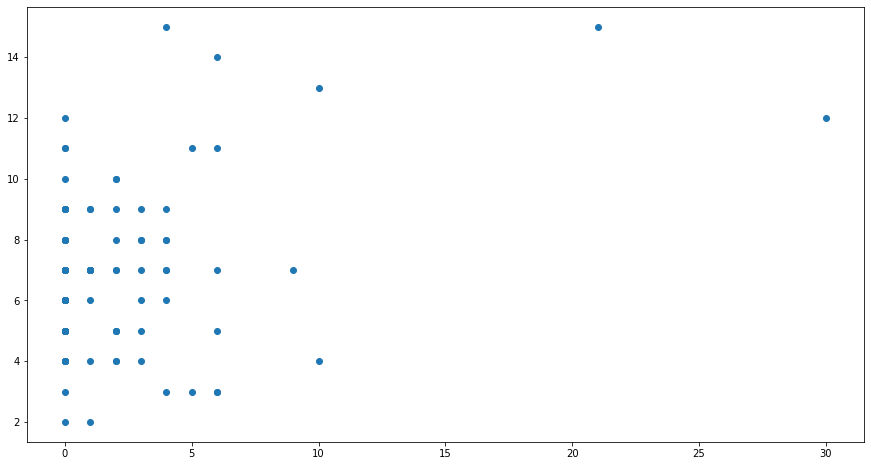

In [67]:
# todo: figure out classes ?
plt.scatter(df["capitals"], df["dashes"])